In [1]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import os
import pprint
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

In [2]:
# lstm model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from matplotlib import pyplot
import keras
from tensorflow.keras.layers import GRU
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import BatchNormalization

In [3]:
Final_Normal_Spec = pd.read_csv("Bin_Final_Normal_Spec.csv")
Final_Normal_Spec = Final_Normal_Spec[:70000]
Final_Fuzz_Spec = pd.read_csv("Bin_Final_Fuzz_Spec.csv")
Final_Fuzz_Spec = Final_Fuzz_Spec[:139586]
Final_DoS_Spec = pd.read_csv("Bin_Final_DoS_Spec.csv")
Final_DoS_Spec = Final_DoS_Spec[:100000]
Final_Replay_Spec = pd.read_csv("Bin_Final_Replay_Spec.csv")

Concat = pd.concat([pd.DataFrame(Final_Normal_Spec.values), pd.DataFrame(Final_Fuzz_Spec.values), 
                    pd.DataFrame(Final_DoS_Spec.values), pd.DataFrame(Final_Replay_Spec.values)], 
                   ignore_index=True) 

In [4]:
145172-5586

139586

In [5]:
Final_DoS_Spec.shape

(100000, 259)

In [6]:
Concat.shape

(360000, 259)

In [7]:
Concat = np.array(Concat)

In [8]:
Final = Concat.reshape(-1,1000,Concat.shape[1])
shuffle_idx = np.random.permutation(Final.shape[0])
Final = Final[shuffle_idx]

In [9]:
print('Old:', Final.shape)
Final = Final.reshape(360000, 259)
print('Updated:',Final.shape)

Old: (360, 1000, 259)
Updated: (360000, 259)


In [10]:
X = Final[:, :258]
y = Final[:,258]

In [11]:
#Data normalization by scalling
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X.shape

(360000, 258)

In [12]:
pd.value_counts(y)

1.0    290000
0.0     70000
dtype: int64

In [13]:
X_trainX = []
y_trainX = []
strat_time = 0
timestamp = 10
length = len(Final)

for i in range(length):
    X_trainX.append(X[strat_time:timestamp, :258])
    y_trainX.append(y[timestamp])
    
    if timestamp >= 360000-10:
        break
    
    strat_time = strat_time + 1
    timestamp = timestamp + 1
print(len(X_trainX))
print(len(y_trainX))

359981
359981


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_trainX, y_trainX, test_size=0.05, random_state=0)

In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
X_train.shape

(341981, 10, 258)

In [17]:
pd.value_counts(y_train)

1.0    275481
0.0     66500
dtype: int64

In [18]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [19]:
print(y_train[0])
print(y_test[64])
print(y_train[2345])
print(y_test[97])

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


In [20]:
X_test.shape

(18000, 10, 258)

In [21]:
print(X_train[0])
print('\n')
print(y_train[0])

[[1.25136550e-04 1.59101808e-05 2.20491218e-05 ... 2.22428554e-07
  4.77306989e-08 8.73027374e-09]
 [7.69859514e-05 1.20265189e-05 1.95204297e-05 ... 2.41640670e-07
  4.66484423e-08 7.38736147e-09]
 [3.64244221e-05 8.07210159e-06 1.68883869e-05 ... 2.38622863e-07
  4.54124727e-08 7.35277629e-09]
 ...
 [1.51767281e-05 1.09664164e-05 2.23414043e-05 ... 7.95680939e-07
  1.53416338e-07 1.28355458e-08]
 [1.18703156e-05 1.30495859e-05 2.84718658e-05 ... 1.21907346e-06
  2.42417105e-07 3.09294712e-08]
 [9.07509041e-06 1.55417214e-05 3.61671783e-05 ... 1.76822619e-06
  3.59183440e-07 6.16254999e-08]]


[0. 1.]


In [22]:
# The GRU architecture
model = Sequential()

model.add(GRU(units=120, return_sequences=True, input_shape=(10, 258), activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(GRU(units=120, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(GRU(units=120, activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.add(Dense(units = 2, activation='sigmoid'))
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [23]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="Final_BIN_GRU.h5",
                               mode='min', monitor='val_loss', verbose=0, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

In [24]:
history = model.fit(X_train, y_train,
                    epochs=150,
                    batch_size=512,
                    shuffle=False,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/150
668/668 [==============================] - 14s 15ms/step - loss: 0.0705 - accuracy: 0.9866 - val_loss: 0.0279 - val_accuracy: 0.9981
Epoch 2/150
668/668 [==============================] - 9s 13ms/step - loss: 0.0163 - accuracy: 0.9983 - val_loss: 0.0149 - val_accuracy: 0.9989
Epoch 3/150
668/668 [==============================] - 9s 13ms/step - loss: 0.0106 - accuracy: 0.9988 - val_loss: 0.0125 - val_accuracy: 0.9992
Epoch 4/150
668/668 [==============================] - 9s 13ms/step - loss: 0.0084 - accuracy: 0.9991 - val_loss: 0.0114 - val_accuracy: 0.9993
Epoch 5/150
668/668 [==============================] - 9s 13ms/step - loss: 0.0075 - accuracy: 0.9992 - val_loss: 0.0106 - val_accuracy: 0.9993
Epoch 6/150
668/668 [==============================] - 9s 13ms/step - loss: 0.0067 - accuracy: 0.9994 - val_loss: 0.0102 - val_accuracy: 0.9993
Epoch 7/150
668/668 [==============================] - 9s 13ms/step - loss: 0.0065 - accuracy: 0.9994 - val_loss: 0.0102 - val_accuracy

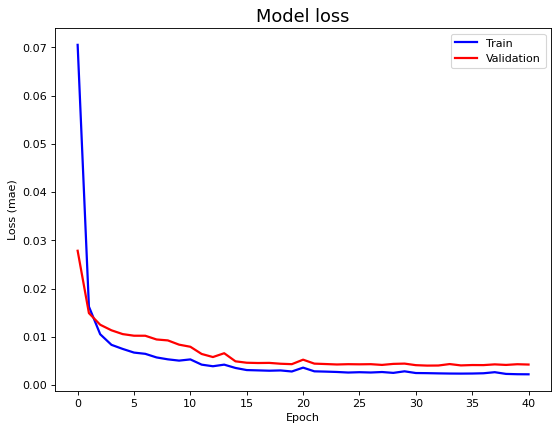

In [25]:
# plot the training losses
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.plot(model.history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(model.history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [26]:
Tesla_Normal_Spec = pd.read_csv("Bin_Tesla_Normal_Spec.csv")
Tesla_Fuzz_Spec = pd.read_csv("Bin_Tesla_Fuzz_Spec.csv")
Tesla_DoS_Spec = pd.read_csv("Bin_Tesla_DoS_Spec.csv")
Tesla_Replay_Spec = pd.read_csv("Bin_Tesla_Replay_Spec.csv")



tesla = pd.concat([pd.DataFrame(Tesla_Normal_Spec.values), pd.DataFrame(Tesla_Fuzz_Spec.values), 
                    pd.DataFrame(Tesla_DoS_Spec.values), pd.DataFrame(Tesla_Replay_Spec.values)], 
                   ignore_index=True) 
print(tesla.shape)

(4433, 259)


In [27]:
print(Concat.shape)

(360000, 259)


In [28]:
tesla = np.array(tesla)

In [29]:
tesla[:,258]

array([0., 0., 0., ..., 1., 1., 1.])

In [30]:
X = tesla[:, :258]
y = tesla[:,258]

In [31]:
#Data normalization by scalling
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X.shape

(4433, 258)

In [32]:
X_trainX = []
y_trainX = []
strat_time = 0
timestamp = 10
length = len(Final)

for i in range(length):
    X_trainX.append(X[strat_time:timestamp, :258])
    y_trainX.append(y[timestamp])
    
    if timestamp >= 4433-10:
        break
    
    strat_time = strat_time + 1
    timestamp = timestamp + 1
print(len(X_trainX))
print(len(y_trainX))

X_trainX = np.array(X_trainX)
y_trainX = np.array(y_trainX)

4414
4414


In [33]:
y_trainX = to_categorical(y_trainX, 2)

In [34]:
y_trainX

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [35]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model = load_model('Final_BIN_GRU.h5')

In [36]:
#Prediction
pred = model.predict(X_trainX)
#obj = scaler.fit(y_pred)
#predicted = obj.inverse_transform(y_pred)

In [37]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(pred, axis=1)
# label
y_test = np.argmax(y_trainX, axis=1)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[1889    0]
 [   1 2524]]


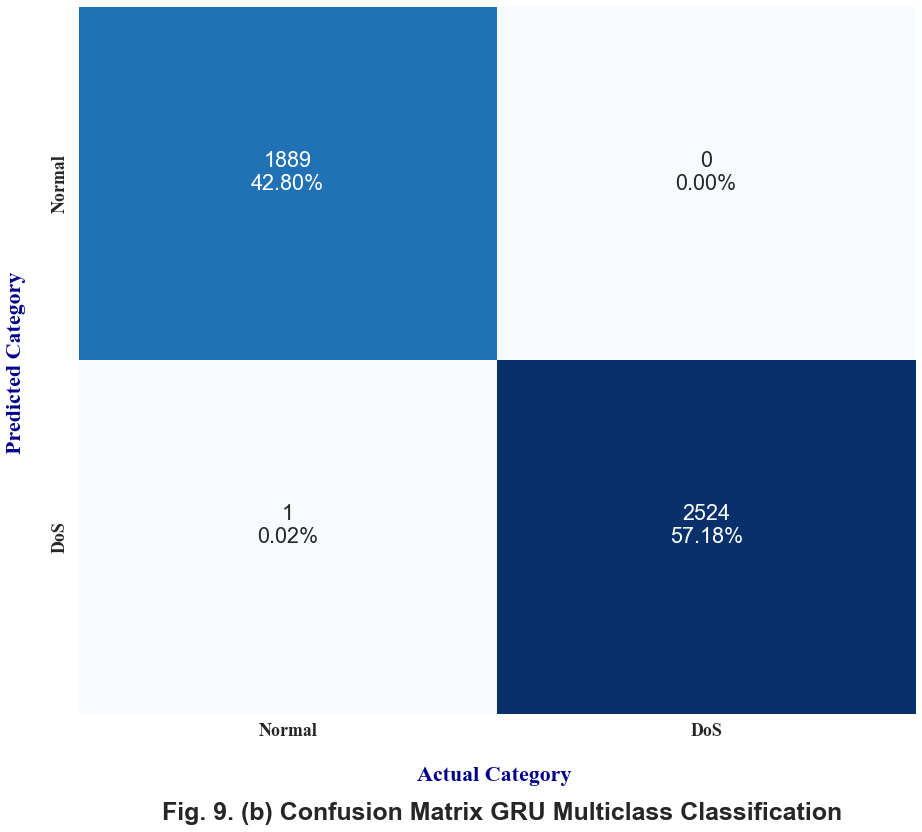

In [38]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.set(rc={'figure.figsize':(15,13)})
sns.set(font_scale=1.8) #edited as suggested
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)


ax.set_xlabel('\nActual Category ', fontname="Times New Roman", size=22,fontweight="bold")
ax.set_ylabel('Predicted Category \n', fontname="Times New Roman", size=22,fontweight="bold");
ax.text(0.2, 2.30, 'Fig. 9. (b) Confusion Matrix GRU Multiclass Classification',fontsize=25,fontweight="bold")

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Normal", "DoS"],fontweight="bold", fontname="Times New Roman", size=18)
ax.yaxis.set_ticklabels(["Normal", "DoS"],fontweight="bold", fontname="Times New Roman", size=18)
ax.xaxis.label.set_color('darkblue')
ax.yaxis.label.set_color('darkblue')
## Display the visualization of the Confusion Matrix.
plt.show()

In [39]:
from sklearn.metrics import classification_report
class_names = ["Normal", "Attack"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1889
      Attack       1.00      1.00      1.00      2525

    accuracy                           1.00      4414
   macro avg       1.00      1.00      1.00      4414
weighted avg       1.00      1.00      1.00      4414



In [40]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9998019801980198

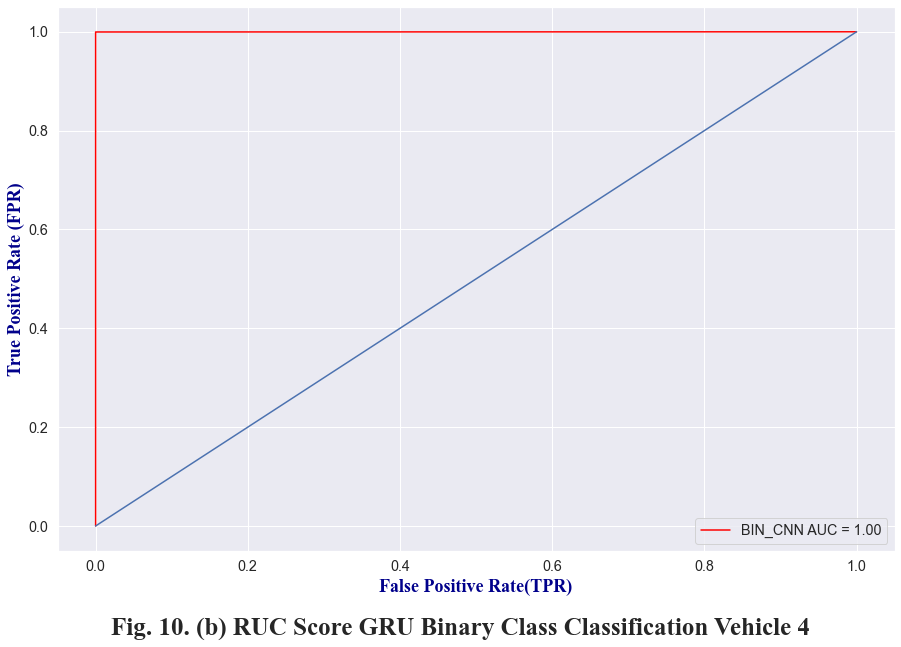

In [41]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=1.3) #edited as suggested

plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'BIN_CNN AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1])

plt.xlabel('False Positive Rate(TPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
plt.ylabel('True Positive Rate (FPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
plt.text(0.02, -0.22, 'Fig. 10. (b) RUC Score GRU Binary Class Classification Vehicle 4', fontname="Times New Roman",fontsize=25,fontweight="bold")
plt.legend(loc="lower right")